In [25]:
import numpy as np
from math import floor, pi, sqrt, asin
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
%matplotlib inline

def apply_phase_oracle(qc: QuantumCircuit, qr: QuantumRegister, target: int):
    n = len(qr)
    # Représentation binaire de la valeur cible (inversée pour correspondre à Qiskit)
    bitstr = format(target, f"0{n}b")[::-1]
    # Positions des bits à 0 dans la valeur cible
    zero_positions = [i for i, b in enumerate(bitstr) if b == "0"]
    # Applique des portes X sur les qubits où la cible a un 0
    # Ceci transforme |target> en |11...1>
    for i in zero_positions:
        qc.x(qr[i])
    # Applique un déphasage (-1) sur l'état |11...1>
    if n == 1:
        # Porte Z : |1> → -|1>
        qc.z(qr[0])
    elif n == 2:
        # Porte CZ : |11> → -|11>
        qc.cz(qr[0], qr[1])
    else:
        # Pour n > 2 : implémentation d’un Z multi-contrôlé
        controls = [qr[i] for i in range(n - 1)]
        target_qubit = qr[n - 1]
        # H transforme Z ↔ X
        qc.h(target_qubit)
        # Porte X multi-contrôlée sur |11...1>
        qc.mcx(controls, target_qubit)
        # Retour à la base originale
        qc.h(target_qubit)
    # Annule les portes X initiales pour restaurer la base d’origine
    # (le déphasage sur |target> est conservé)
    for i in zero_positions:
        qc.x(qr[i])

def diffusion_operator(qc: QuantumCircuit, qr: QuantumRegister):
    n = len(qr)
    # Applique H sur tous les qubits :
    # |x> → superposition uniforme
    qc.h(qr)
    # Applique X sur tous les qubits :
    # |0...0> ↔ |1...1>
    qc.x(qr)
    # Applique un déphasage sur |11...1>
    if n == 1:
        qc.z(qr[0])
    elif n == 2:
        qc.cz(qr[0], qr[1])
    else:
        controls = [qr[i] for i in range(n - 1)]
        target_qubit = qr[n - 1]
        # Implémentation d’un Z multi-contrôlé
        qc.h(target_qubit)
        qc.mcx(controls, target_qubit)
        qc.h(target_qubit)
    # Annule les portes X et H pour compléter l'inversion
    qc.x(qr)
    qc.h(qr)

def build_grover_circuit(n: int, target: int, iterations: int = None, measure: bool = True):
    qr = QuantumRegister(n, "q")
    cr = ClassicalRegister(n, "c")
    qc = QuantumCircuit(qr, cr)
    # Préparation de l'état uniforme |s>
    qc.h(qr)
    N = 2 ** n
    # Nombre optimal d'itérations de Grover
    if iterations is None:
        r = max(1, int(floor((pi / 4) * sqrt(N))))
    else:
        r = int(iterations)
    # Applique r itérations de Grover : Oracle puis Diffusion
    for _ in range(r):
        apply_phase_oracle(qc, qr, target)
        diffusion_operator(qc, qr)
    # Mesure finale
    if measure:
        qc.measure(qr, cr)
    return qc, r


def statevector_counts(qc: QuantumCircuit, shots: int = 1024):
    n = qc.num_qubits
    # Récupère le vecteur d'état final
    sv = Statevector.from_instruction(qc)
    # Probabilités de chaque état
    probs = np.abs(sv.data) ** 2
    probs = probs / np.sum(probs)
    # Tirage aléatoire selon les probabilités
    outcomes = np.arange(len(probs))
    samples = np.random.choice(outcomes, size=shots, p=probs)
    # Comptage des résultats
    counts = {}
    for s in samples:
        bitstr = format(int(s), f"0{n}b")
        counts[bitstr] = counts.get(bitstr, 0) + 1

    return counts

def run_and_plot(qc: QuantumCircuit, shots: int = 1024):
    qc_display = qc.copy()
    # Vérifie si une mesure est déjà présente
    ops = qc_display.count_ops()
    has_measure = ops.get("measure", 0) > 0
    # Ajoute une mesure si nécessaire
    if not has_measure and qc_display.num_qubits > 0 and qc_display.num_clbits > 0:
        qr = qc_display.qregs[0]
        cr = qc_display.cregs[0]
        qc_display.measure(qr, cr)
    # Affichage du circuit
    fig = qc_display.draw(output="mpl", idle_wires=False)
    plt.show(fig)
    # Simulation et histogramme
    counts = statevector_counts(qc, shots=shots)
    plot_histogram(counts)
    plt.show()
    # Résultat le plus probable
    most_likely = max(counts, key=counts.get)
    print(f"État mesuré le plus probable : {most_likely}")
    return counts

def theoretical_probability(N: int, r: int) -> float:
    theta = asin(1.0 / sqrt(N))
    return np.sin((2 * r + 1) * theta) ** 2


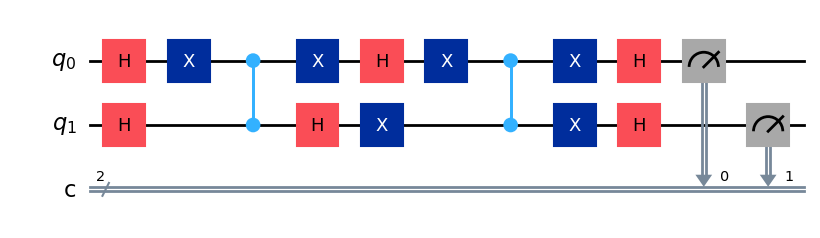

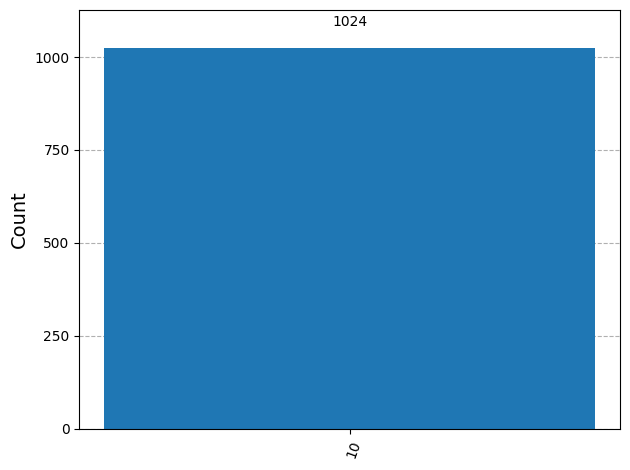

État mesuré le plus probable : 10


In [26]:
# Activité 1
def run_grover_2qubit(target_binary: str = "10", shots: int = 1024):
    # Conversion de la chaîne binaire fournie en entier pour l’oracle
    target_int = int(target_binary, 2)
    # Fixé pour cette activité : 2 qubits et 1 itération
    n = 2
    iterations = 1
    qc, r_used = build_grover_circuit(n, target_int, iterations, measure=False)
    counts = run_and_plot(qc, shots=shots)
    return counts


if __name__ == "__main__":
    run_grover_2qubit("10", shots=1024)

# Observations :
# On remarque que l’histogramme obtenu ne contient qu’un seul résultat,
# ce qui signifie que la probabilité d’obtenir cet état est de 100 %.
# Le seul résultat est "10" (soit l’entier 2), donc l’état correct est mesuré à chaque fois,
# ce qui indique que la simulation est idéale.
# Cela est confirmé par le calcul théorique du nombre optimal d’itérations de Grover :
# floor((π/4) × sqrt(N/M)) avec N = 4 et M = 1
# floor((π/4) × sqrt(4/1)) → floor((π/4) × 2) = 1
# Une seule itération est donc le choix correct / optimal.

r= 1  empirical=0.7832 (802/1024)  theoretical=0.7812
r= 2  empirical=0.9482 (971/1024)  theoretical=0.9453
r= 3  empirical=0.3359 (344/1024)  theoretical=0.3301
r= 4  empirical=0.0137 (14/1024)  theoretical=0.0122
r= 5  empirical=0.5430 (556/1024)  theoretical=0.5480
r= 6  empirical=1.0000 (1024/1024)  theoretical=0.9998
r= 7  empirical=0.5596 (573/1024)  theoretical=0.5770
r= 8  empirical=0.0166 (17/1024)  theoretical=0.0195
r= 9  empirical=0.3057 (313/1024)  theoretical=0.3029
r=10  empirical=0.9355 (958/1024)  theoretical=0.9313
r=11  empirical=0.8145 (834/1024)  theoretical=0.8049
r=12  empirical=0.1504 (154/1024)  theoretical=0.1450
r=13  empirical=0.0938 (96/1024)  theoretical=0.1063
r=14  empirical=0.7510 (769/1024)  theoretical=0.7566
r=15  empirical=0.9580 (981/1024)  theoretical=0.9578
r=16  empirical=0.3604 (369/1024)  theoretical=0.3578
r=17  empirical=0.0049 (5/1024)  theoretical=0.0066
r=18  empirical=0.5283 (541/1024)  theoretical=0.5188
r=19  empirical=1.0000 (1024/102

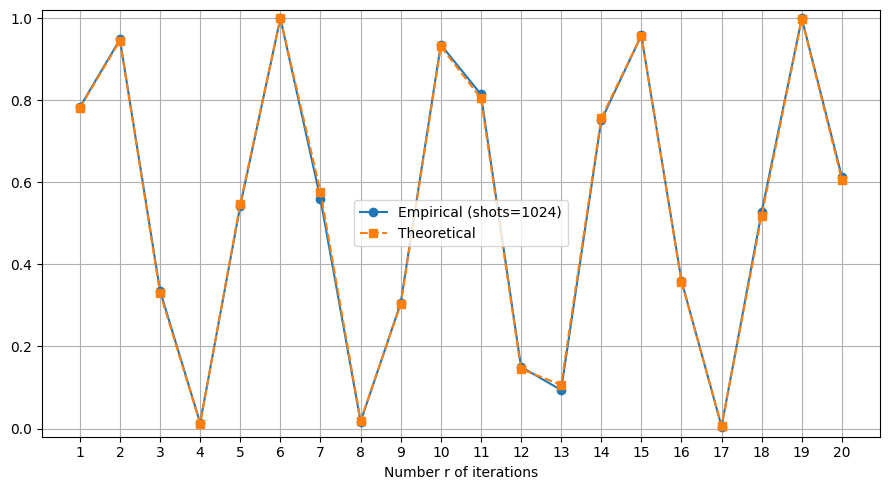

In [27]:
# Activité 2
def run_grover_3qubit_scan(target_binary: str = "101", r_max: int = 20, shots: int = 1024):
    # Conversion de la chaîne binaire fournie en entier pour l’oracle
    target_int = int(target_binary, 2)
    # Fixé pour cette activité : 3 qubit
    N = 2 ** 3
    rs = list(range(1, r_max + 1))
    empirical_probs = []
    theoretical_probs = []
    for r in rs:
        qc, _ = build_grover_circuit(3, target_int, iterations=r, measure=False)
        counts = statevector_counts(qc, shots=shots)
        success_counts = counts.get(target_binary, 0)
        p_emp = success_counts / shots
        p_theo = theoretical_probability(N, r)
        empirical_probs.append(p_emp)
        theoretical_probs.append(p_theo)
        print(f"r={r:2d}  empirical={p_emp:.4f} ({success_counts}/{shots})  theoretical={p_theo:.4f}")
    plt.figure(figsize=(9, 5))
    plt.plot(rs, empirical_probs, 'o-', label='Empirical (shots={})'.format(shots))
    plt.plot(rs, theoretical_probs, 's--', label='Theoretical')
    plt.xlabel('Success probability')
    plt.xlabel('Number r of iterations')
    plt.xticks(rs)
    plt.ylim(-0.02, 1.02)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_grover_3qubit_scan(target_binary="101", r_max=20, shots=1024)

# Observations :
# Lorsque l’on augmente le nombre d’itérations, les résultats oscillent,
# car on effectue des rotations dans un espace à deux dimensions d’un angle 2θ,
# où sin(θ) = sqrt(M / N).
# On observe donc qu’à mesure que r augmente, la probabilité de succès
# augmente jusqu’à un maximum, puis redescend lorsque l’on « dépasse » ce maximum.
# En observant le graphique, on remarque que le premier maximum (et donc la meilleure itération)
# est atteint pour r = 2.
# Cela peut être confirmé par la formule théorique :
# floor((π / 4) × sqrt(N / M)) avec N = 8 et M = 2
# floor((π / 4) × sqrt(8 / 2)) → floor((π / 4) × 2) = 1